In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv'

In [6]:
# Get the list of column names
print(df.columns.tolist())

['source', 'id', 'date', 'gwl_cm', 'lat', 'lon', 'LIA', 'VH', 'VV', 'VVVH_ratio', 'angle', 'sm_1', 'sm_3', 'sm_7', 'sm_30', 'precipitation', 'prec_3', 'prec_7', 'prec_30', 'elevation', 'aspect', 'slope', 'land_cov', 'canopy_height', 'gldas_mean', 'gldas_stddev', 'B3', 'B4', 'B5', 'B7', 'ndvi', 'ndmi', 'ndbri', 'distance', 'dir', 'acc', 'doy', 'region_id', 'geometry', 'index_right', 'island', 'province', 'phu_name', 'aoi_phu', 'tile_id', 'phu_id']


In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/home/sepal-user/module-venv/gwl-modeling/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/sepal-user/module-venv/gwl-modeling/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/sepal-user/module-venv/gwl-modeling/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/sepal-user/module-venv/gwl-modeling/lib/python3.10/site-packages/sklearn/cluster/_kme

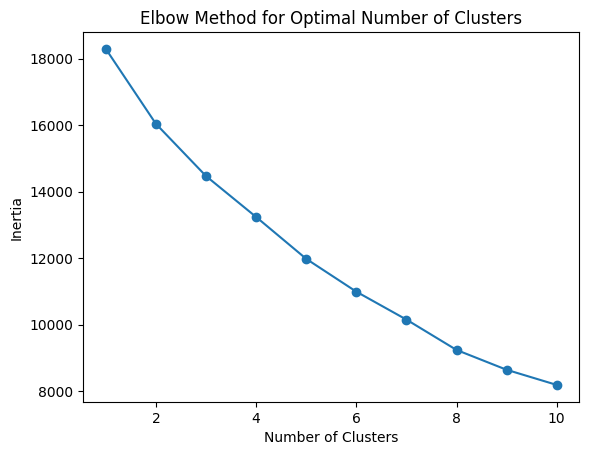

                id      lat        lon  elevation      aspect     slope  \
0  02_AHL_SBG-B076  3.93776  117.00775         33   45.067711  5.238249   
1  02_AHL_SBG-B101  3.93186  117.01012         22  326.247587  3.342748   
2  02_AHL_SBG-B103  3.92609  117.00521         37   31.023181  5.395520   
3  02_AHL_SBG-C003  3.90340  117.14543         32  314.933469  1.312966   
4  02_AHL_SBG-C006  3.91938  117.14832         22  126.805520  4.634283   

   land_cov  canopy_height     distance  dir  acc  gwl_cm  cluster  
0       160             24  4519.468722    1    1   -33.0        2  
1        30             15  5020.676546  128   36   -52.4        2  
2        40             21  4898.636465   64    2   -33.0        2  
3       160             22  1678.548906    4    1   -27.8        1  
4        11             16  1459.469969  128    1   -18.2        0  
                   id       lat         lon  elevation      aspect     slope  \
0     02_AHL_SBG-B076  3.937760  117.007750         33 

/home/sepal-user/module-venv/gwl-modeling/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
# Select relevant columns for clustering
columns_to_keep = ['id', 'lat', 'lon', 'elevation', 'aspect', 'slope', 'land_cov', 'canopy_height', 'distance', 'dir', 'acc', 'gwl_cm']

# Retain only the selected columns
df = df[columns_to_keep]

# Aggregate GWL measurements (e.g., by mean)
df_gwl_agg = df.groupby('id').agg({
    'lat': 'first',
    'lon': 'first',
    'elevation': 'first',
    'aspect': 'first',
    'slope': 'first',
    'land_cov': 'first',
    'canopy_height': 'first',
    'distance': 'first',
    'dir': 'first',
    'acc': 'first',
    'gwl_cm': 'mean'
}).reset_index()

# Normalize the data for clustering (excluding 'id', 'latitude', 'longitude')
features = df_gwl_agg.drop(columns=['id', 'lat', 'lon'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(normalized_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# From the elbow plot, choose the optimal number of clusters (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

# Add cluster labels to the aggregated DataFrame
df_gwl_agg['cluster'] = clusters

# Display the cleaned and clustered DataFrame
print(df_gwl_agg.head())
print(df_gwl_agg)

# Save the DataFrame to a CSV file for further analysis or mapping
df_gwl_agg.to_csv("data/8_cluster_stations/clustered_dipwells.csv", index=False)

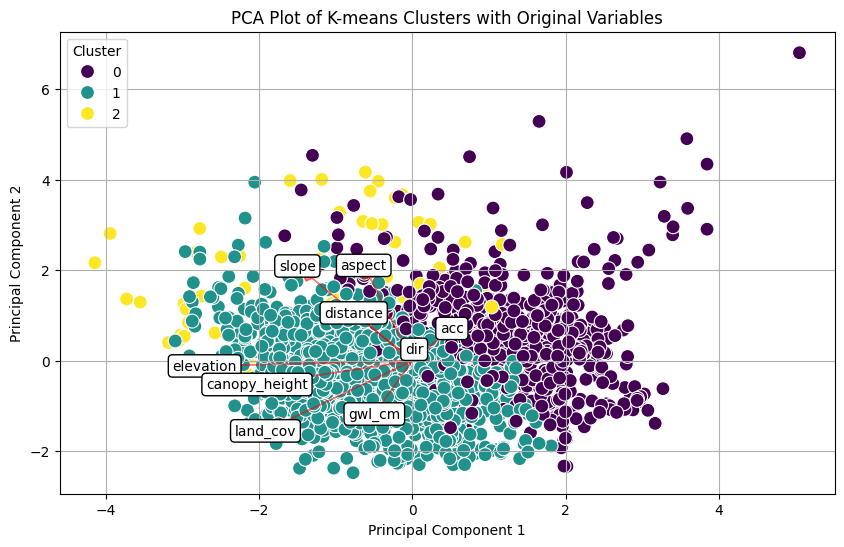

In [24]:
# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_features)

# Create a DataFrame with the PCA components and the cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# Calculate the loading scores for the original variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Scale the loadings for exaggeration
scaling_factor = 3  # Increase this value to exaggerate the vectors more
loadings_exaggerated = loadings * scaling_factor

# Plot the PCA components with the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA Plot of K-means Clusters with Original Variables')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

# Plot the exaggerated original variables as vectors
for i, var in enumerate(features.columns):
    plt.arrow(0, 0, loadings_exaggerated[i, 0], loadings_exaggerated[i, 1], color='r', alpha=0.5, head_width=0.2)
    plt.text(loadings_exaggerated[i, 0] * 1.15, loadings_exaggerated[i, 1] * 1.15, var, color='black', ha='center', va='center',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.grid()
plt.show()

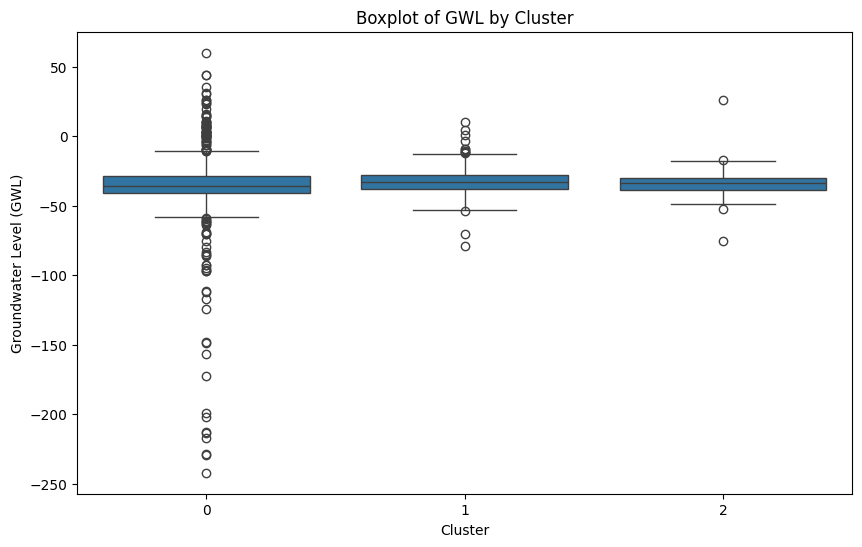

In [20]:
#make a boxplot to check for differences in the clusters
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='gwl_cm', data=df_gwl_agg)
plt.title('Boxplot of GWL by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Groundwater Level (GWL)')
plt.show()